In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os
# print(os.listdir("../input"))
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv(r'C:\Users\Pundeer\Desktop\Data Science\Kaggle\Fake news\fake new classification\train.csv')

data = data.sample(frac = 1)
data.head()

,id,title,author,text,label
19082,19082,Freezing Migrant Rescued by Border Patrol Agents,Bob Price,A migrant attempting to cross the border into ...,0
6341,6341,Russian Spacecraft Carrying Supplies Burns Up ...,Kenneth Chang,A Russian spacecraft carrying 2. 6 tons of foo...,0
9709,9709,UC Berkeley Administration Won’t Budge On Secu...,Lucas Nolan,UC Berkeley’s administration has replied to th...,0
12913,12913,How to Survive Being Lost in the Woods: Tips &...,Prepper Website,Posted by Devin Peterson on 11/16/2016 to Outd...,1
10751,10751,UK Child Protection Services workers are ‘afra...,BareNakedIslam,BNI Store Oct 27 2016 UK Child Protection Serv...,1


In [65]:
data.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 19082 to 9168
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 975.0+ KB


### Distribution of News in Dataset

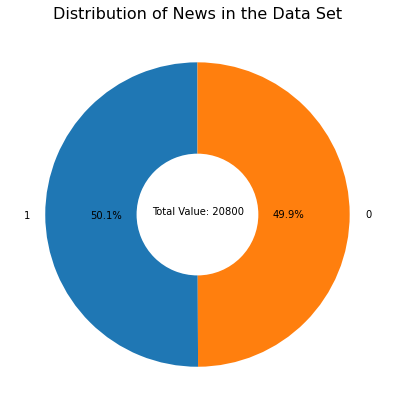

In [6]:
plt.figure(figsize = (7,7))
counts = data['label'].value_counts()
plt.pie(counts, labels = counts.index, startangle = 90, wedgeprops = {'width' : 0.6}, autopct='%1.1f%%')

plt.text(x = -0.3, y = 0, s = 'Total Value: {}'.format(data.shape[0]))
plt.title('Distribution of News in the Data Set', fontsize = 16);

In [77]:
x_data = data[~data.text.isnull()].text
y_data = data[~data.text.isnull()].label
print(x_data.isnull().value_counts(), y_data.isnull().value_counts())

False    20761
Name: text, dtype: int64 False    20761
Name: label, dtype: int64


### Cleaning special characters

In [78]:
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [79]:
def tokenize(string):
    string = re.sub('[^a-zA-Z]', ' ', string)
    string = string.lower()
    string = string.split()
    words = set(stopwords.words("english"))
    return [i for i in string if i not in words]

x_data = x_data.apply(lambda x: tokenize(x))

In [114]:
nltk.download('averaged_perceptron_tagger')
def lemmatize(string):
    lemma = WordNetLemmatizer()
    text = []
    for word, tag in pos_tag(string):
        wtag = tag[0].lower()
        wtag = wtag if wtag in ['n', 'v', 'r', 'a'] else None
        spell = lemma.lemmatize(word, wtag) if wtag else word
        text.append(spell)
    return (' '.join([w for w in text if len(w)>2]))

#x_data
train_data = x_data.apply(lambda x: lemmatize(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pundeer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### TFIDF Vectorizer

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))
X = tfidf.fit_transform(train_data).toarray()

In [132]:
len(tfidf.get_feature_names())

5000

In [133]:
vec_data = pd.DataFrame(X , columns = tfidf.get_feature_names())

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vec_data, y_data, test_size=0.2, random_state=0)

In [145]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 10)
Ada.fit(X_train, y_train)
print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Ada.score(X_train, y_train)))
print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Ada.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.91
Accuracy of Adaboost classifier on test set: 0.90


In [141]:
rfc = RandomForestClassifier(n_estimators = 50)
rfc.fit(X_train, y_train)
print('Accuracy of Randomforest classifier on training set: {:.2f}'.format(rfc.score(X_train, y_train)))
print('Accuracy of Randomforest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))

Accuracy of Randomforest classifier on training set: 1.00
Accuracy of Randomforest classifier on test set: 0.92


In [138]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
print('Accuracy of NavierBayes  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))
print('Accuracy of NavierBayes classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))

Accuracy of NavierBayes  classifier on training set: 0.89
Accuracy of NavierBayes classifier on test set: 0.87


In [139]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Lasso classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Lasso classifier on training set: 0.96
Accuracy of Lasso classifier on test set: 0.94


### Using LSTM

In [204]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, Activation
from keras.callbacks import EarlyStopping

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [189]:
tok_num = 4000
data_len = 3000
dropout = 0.2

In [190]:
token = Tokenizer(num_words = tok_num)
token.fit_on_texts(train_data)

In [210]:
data_seq = token.texts_to_sequences(train_data)

In [211]:
x_train = pad_sequences(data_seq, maxlen = data_len)

In [212]:
model = Sequential()
model.add(Embedding(output_dim=32, input_dim = tok_num, input_length=data_len))
#model.add(Dropout(dropout))

model.add(LSTM(100))
model.add(Dropout(dropout))

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(dropout))

model.add(Dense(units = 1, activation = 'sigmoid'))
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 3000, 32)          128000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 187,729
Trainable params: 187,729
Non-trainable params: 0
________________________________________________

In [213]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [214]:
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 2)

In [ ]:
hist = model.fit(x=x_train, y=y_data, validation_split=0.25, epochs=10, batch_size=200, verbose=1, callbacks=[es])

C:\Users\Pundeer\.conda\envs\friday\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14532 samples, validate on 6229 samples
Epoch 1/10
12800/14532 [=========================>....] - ETA: 43:45 - loss: 0.5879 - accuracy: 0.6805

In [202]:
%matplotlib inline
def show_train_history(train_history, train, validation):
    plt.plot(hist.history[train])
    plt.plot(hist.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

In [203]:
show_train_history(hist, 'acc', 'val_acc')
show_train_history(hist, 'loss', 'val_loss')

NameError: name 'hist' is not defined